# MFDGP model for malaria data

This notebook fits the MF-DGP model to malaria data. We assume the low fidelity is data from the year 2005 and high fidelity is data from 2015. 

The inputs to the model are the latitude/longitude points and the is the infection rate of malaria among children which varies between 0 and 1. 

Where the data is < 0, that means we have no data so these points are discarded. 

We use all the data from the low fidelity, and take a small subsample from the high fidelity then test against the remaining high fidelity data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from .multi_fidelity_deep_gp import DGP_Base, init_layers_mf
from gpflow.kernels import RBF, White, Linear
from gpflow.likelihoods import Gaussian
from gpflow.actions import Loop, Action
from gpflow.mean_functions import Zero
from gpflow.training import AdamOptimizer
import gpflow.training.monitor as mon

In [2]:
def make_dgpMF_model(X, Y, Z):
    
    L = len(X)

    Din = X[0].shape[1]
    Dout = Y[0].shape[1]

    kernels = []
    k_2 = RBF(Din, active_dims=list(range(Din)), variance=1., lengthscales=10., ARD=True)
    kernels.append(k_2)
    for l in range(1,L):
        
        D = Din + Dout
        D_range = list(range(D))
        k_corr_2 = RBF(Din, active_dims=D_range[:Din], lengthscales=0.1,  variance=1.5, ARD=True)
        k_corr = k_corr_2
        
        k_prev = RBF(Dout, active_dims=D_range[Din:], variance = 1., lengthscales=0.1, ARD=True)
        k_in = RBF(Din, active_dims=D_range[:Din], variance=0.1, lengthscales=1., ARD=True)
        k_bias = Linear(Dout, active_dims=D_range[Din:], variance = 1e-6)
        k_in.variance = 1e-6
        k_l = k_corr*(k_prev + k_bias) + k_in
        kernels.append(k_l)

    '''
    A White noise kernel is currently expected by Mf-DGP at all layers except the last.
    In cases where no noise is desired, this should be set to 0 and fixed, as follows:
    
        white = White(1, variance=0.)
        white.variance.trainable = False
        kernels[i] += white
    '''
    for i, kernel in enumerate(kernels[:-1]):
        kernels[i] += White(1, variance=0.)
            
    num_data = 0
    for i in range(len(X)):
        print('\nData at Fidelity ', (i+1))
        print('X - ', X[i].shape)
        print('Y - ', Y[i].shape)
        print('Z - ', Z[i].shape)
        num_data += X[i].shape[0]
        
    layers = init_layers_mf(Y, Z, kernels, num_outputs=1)
        
    model = DGP_Base(X, Y, Gaussian(), layers, num_samples=10, minibatch_size=1000)

    return model

# Load data

To download data go to [https://map.ox.ac.uk/explorer/#/](https://map.ox.ac.uk/explorer/#/) and select the layer `Plasmodium falciparum parasite rate in 2-10 year olds in Africa` and click download. Select the zip file option. You should then have a zip file called `2015_Nature_Africa_PR.2000.zip`.

Unzip the folder and enter the folder locaiton below.

In [3]:
import os
import pandas as pd

data_folder_location = '~/Downloads/2015_Nature_Africa_PR.2000/'

name_lf = '2015_Nature_Africa_PR.2005.tif'
name_hf = '2015_Nature_Africa_PR.2015.tif'
if not os.path.exists(name_lf[:-3] + 'csv'):
    import georaster
    def get_map_as_df(path):
        my_image = georaster.SingleBandRaster(path, load_data=False)
        return pd.DataFrame(data=np.stack([my_image.coordinates()[1].flatten(), my_image.coordinates()[0].flatten(),
                      my_image.read_single_band(1).flatten()], axis=1), columns=['latitude', 'longitude', 'value'])
    
    lf_data = get_map_as_df(os.path.join(data_folder_location, name_lf))
    hf_data = get_map_as_df(os.path.join(data_folder_location, name_hf))
        
    
else:
    lf_data = pd.read_csv(name_lf[:-3] + 'csv')
    hf_data = pd.read_csv(name_hf[:-3] + 'csv')

**Change paths to where your data is stored**

In [4]:
import scipy.special

# Discard points where we have no data
lf_valid = lf_data.value > 0
hf_valid = hf_data.value > 0

y_lf = lf_data.value.values[lf_valid, None]
y_hf = hf_data.value.values[hf_valid, None]

# Transform data so it lies on real line
y_lf_transformed = scipy.special.logit(y_lf)
y_hf_transformed = scipy.special.logit(y_hf)

# Construct features
x_lf = np.stack([lf_data.latitude.values[lf_valid], lf_data.longitude.values[lf_valid]], axis=1)
x_hf = np.stack([hf_data.latitude.values[hf_valid], hf_data.longitude.values[hf_valid]], axis=1)

# Choose a random subset of high fidelity points for training
np.random.seed(0)
i_train = np.random.choice(x_hf.shape[0], 1000, replace=False)

x_hf_train = x_hf[i_train, :]
y_hf_train = y_hf_transformed[i_train, :]

### Initialze inducing points to a subset of the data

In [5]:
i_z = np.random.choice(x_lf.shape[0], 1000, replace=False)
z_low = x_lf[i_z, :]

i_z_low = np.random.choice(x_lf.shape[0], 1000, replace=False)
z_high = np.concatenate([x_lf[i_z_low, :], y_lf_transformed[i_z_low, :]], axis=1)

In [6]:
dgp = make_dgpMF_model([x_lf, x_hf_train], [y_lf_transformed, y_hf_train], [z_low, z_high])


Data at Fidelity  1
X -  (890223, 2)
Y -  (890223, 1)
Z -  (1000, 2)

Data at Fidelity  2
X -  (1000, 2)
Y -  (1000, 1)
Z -  (1000, 3)


### Trainining loop + some printing

In [7]:
class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        if ctx.iteration % 500 == 0:
            likelihood = ctx.session.run(self.model.likelihood_tensor)
            objective = ctx.session.run(self.model.objective)

            print('ELBO {:.4f};  KL {:,.4f}'.format(ctx.session.run(self.model.L), ctx.session.run(self.model.KL)))
            print('{}: iteration {} objective {:,.4f}'.format(self.text, ctx.iteration, objective))


def run_adam(model, lr, iterations, callback=None):
    adam = AdamOptimizer(lr).make_optimize_action(model)
    actions = [adam] if callback is None else [adam, callback]
    loop = Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

In [8]:
dgp.layers[0].feature.Z.trainable = False
dgp.layers[1].feature.Z.trainable = False

In [9]:
dgp.layers[0].q_sqrt = dgp.layers[0].q_sqrt.value * 1e-6
dgp.layers[0].q_sqrt.trainable = False
dgp.likelihood.likelihood.variance = y_hf_train.var() * .01
dgp.likelihood.likelihood.variance.trainable = False
dgp.run_adam(0.01, 15000)
dgp.likelihood.likelihood.variance.trainable = True
dgp.layers[0].q_sqrt.trainable = True
dgp.run_adam(3e-3, 10000)

ELBO -1569014674503.0532;  KL 17677.8067
MF-DGP with Adam: iteration 0 objective 1652467750648.4907
ELBO -361203559180.6258;  KL 28573676.4730
MF-DGP with Adam: iteration 250 objective 301189261987.8177
ELBO -157876835104.9217;  KL 42239407.3282
MF-DGP with Adam: iteration 500 objective 156051565458.3528
ELBO -72876943723.0534;  KL 32116628.9174
MF-DGP with Adam: iteration 750 objective 68328336283.9842
ELBO -5385024297.2355;  KL 3832599.0182
MF-DGP with Adam: iteration 1000 objective 5919818529.4187
ELBO -2407896188.2673;  KL 1903467.0422
MF-DGP with Adam: iteration 1250 objective 2361432972.6956
ELBO -1769112707.4240;  KL 1213841.2373
MF-DGP with Adam: iteration 1500 objective 1652779095.3837
ELBO -1093491210.9303;  KL 833403.6591
MF-DGP with Adam: iteration 1750 objective 1130089478.6339
ELBO -853720306.2662;  KL 616507.8698
MF-DGP with Adam: iteration 2000 objective 762173676.8963
ELBO -639610106.7812;  KL 486452.8034
MF-DGP with Adam: iteration 2250 objective 615005819.3909
ELBO -

ELBO -1059923.3436;  KL 7050.0123
MF-DGP with Adam: iteration 8000 objective 1054230.2531
ELBO -1025246.3326;  KL 7508.1316
MF-DGP with Adam: iteration 8250 objective 990014.9206
ELBO -1035329.5113;  KL 7948.7855
MF-DGP with Adam: iteration 8500 objective 1007256.1250
ELBO -1004405.5824;  KL 7805.8866
MF-DGP with Adam: iteration 8750 objective 1023079.9592
ELBO -1010378.9417;  KL 8271.1813
MF-DGP with Adam: iteration 9000 objective 1075956.8830
ELBO -976763.2435;  KL 8706.7852
MF-DGP with Adam: iteration 9250 objective 1016948.7220
ELBO -983489.8804;  KL 8733.2779
MF-DGP with Adam: iteration 9500 objective 1074978.7496
ELBO -1020818.3783;  KL 8882.9154
MF-DGP with Adam: iteration 9750 objective 993306.4550


# Test against a subset of high fidelity data

In [10]:
n_test = 10000
idxs = np.arange(0, y_hf.shape[0])
idxs_minus_train = np.array(list(set(idxs) - set(i_train)))
np.random.seed(123)
i_test = np.random.choice(idxs_minus_train, n_test, replace=False)

In [11]:
x_test = x_hf[i_test, :]
y_test = y_hf[i_test, :]

In [12]:
import scipy
# batch predict
batch_size = 1000
n_batches = int(np.ceil(n_test/batch_size))
y_result = np.zeros(n_test)
for i in range(n_batches):
    i_start = i*batch_size
    i_end = np.min([(i+1) * batch_size, n_test])
    transformed_predictions = dgp.predict_f(x_test[i_start:i_end, :], 50)[0].mean(axis=0)
    y_result[i_start:i_end] = scipy.special.expit(transformed_predictions)[:, 0]

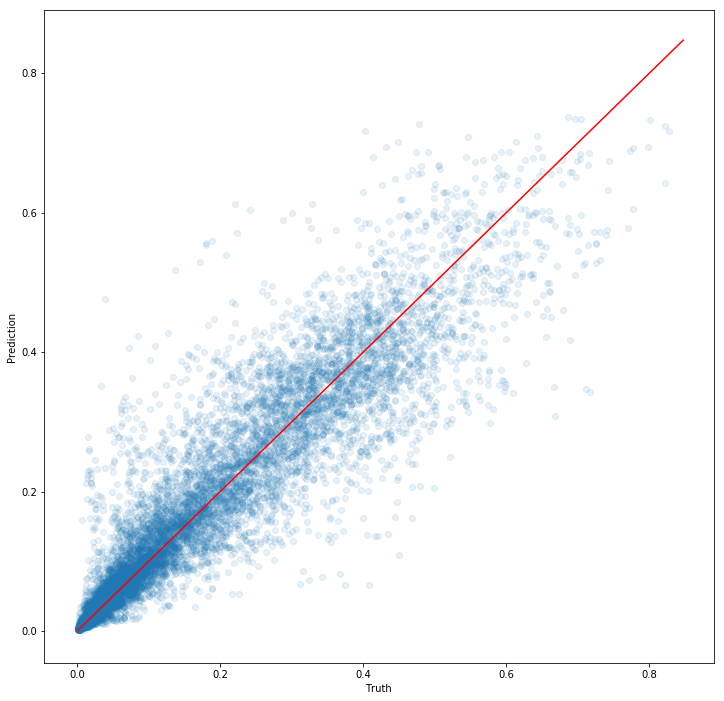

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(y_test, y_result, alpha=0.1)
min_max = [y_hf.min(), y_hf.max()]
plt.plot(min_max, min_max, color='r')
plt.xlabel('Truth')
plt.ylabel('Prediction');

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print(r2_score(y_test, y_result))
print(np.sqrt(mean_squared_error(y_test, y_result)))
print(mean_absolute_error(y_test, y_result))

0.8435558967879343
0.06305989579983723
0.03951389899713894
